In [3]:
!pip install matplotlib
!pip install tensorflow 


     ---------------------------------------- 0.0/24.4 MB ? eta -:--:--
     ---------------------------------------- 0.1/24.4 MB ? eta -:--:--
     ---------------------------------------- 0.1/24.4 MB ? eta -:--:--
     ---------------------------------------- 0.1/24.4 MB ? eta -:--:--
     ---------------------------------------- 0.1/24.4 MB ? eta -:--:--
     ---------------------------------------- 0.1/24.4 MB ? eta -:--:--
     ---------------------------------------- 0.1/24.4 MB ? eta -:--:--
     ---------------------------------------- 0.1/24.4 MB ? eta -:--:--
     ---------------------------------------- 0.1/24.4 MB ? eta -:--:--
     ---------------------------------------- 0.1/24.4 MB ? eta -:--:--
     ---------------------------------------- 0.1/24.4 MB ? eta -:--:--
     ---------------------------------------- 0.1/24.4 MB ? eta -:--:--
     ---------------------------------------- 0.1/24.4 MB ? eta -:--:--
     --------------------------------------- 0.1/24.4 MB 147.8 k

In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from IPython.display import HTML

In [63]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=50

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "plant village",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [8]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
len(dataset)

68

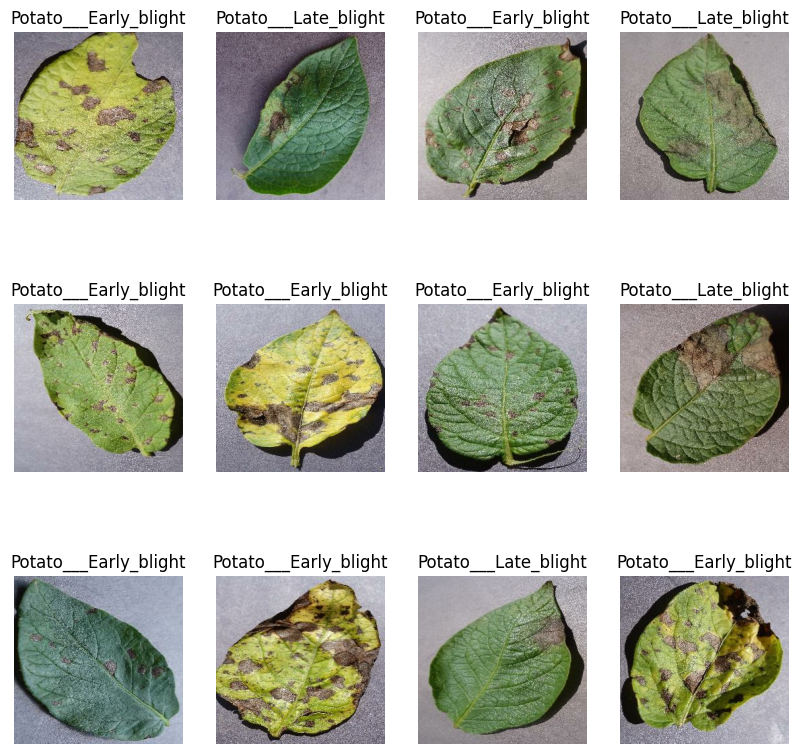

In [15]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [16]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [17]:
train_ds=dataset.take(54)
len(train_ds)

54

In [18]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [19]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [20]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [21]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [41]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [24]:
len(train_ds)

54

In [25]:
len(val_ds)

6

In [26]:
len(test_ds)

8

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE

In [33]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [40]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [44]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [64]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [65]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     multiple                  0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

In [66]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [67]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 150s 3s/step - loss: 0.9117 - accuracy: 0.5041 - val_loss: 0.8815 - val_accuracy: 0.5833
Epoch 2/50
54/54 [==============================] - 120s 2s/step - loss: 0.7535 - accuracy: 0.6672 - val_loss: 0.4861 - val_accuracy: 0.8281
Epoch 3/50
54/54 [==============================] - 109s 2s/step - loss: 0.4687 - accuracy: 0.8050 - val_loss: 0.3648 - val_accuracy: 0.8490
Epoch 4/50
54/54 [==============================] - 115s 2s/step - loss: 0.2356 - accuracy: 0.9109 - val_loss: 0.3872 - val_accuracy: 0.8438
Epoch 5/50
54/54 [==============================] - 112s 2s/step - loss: 0.1831 - accuracy: 0.9317 - val_loss: 0.4130 - val_accuracy: 0.8385
Epoch 6/50
54/54 [==============================] - 111s 2s/step - loss: 0.1414 - accuracy: 0.9479 - val_loss: 0.0984 - val_accuracy: 0.9688
Epoch 7/50
54/54 [==============================] - 111s 2s/step - loss: 0.1805 - accuracy: 0.9306 - val_loss: 0.2056 - val_accuracy: 0.9167
Epoch 8/50
54

In [70]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 4s 350ms/step - loss: 0.0541 - accuracy: 0.9828


In [71]:
scores

[0.05408015474677086, 0.982758641242981]

In [72]:
history

In [73]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [75]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [76]:
history.history['accuracy']

[0.5040509104728699,
 0.6672453880310059,
 0.8049768805503845,
 0.9108796119689941,
 0.9317129850387573,
 0.9479166865348816,
 0.9305555820465088,
 0.9646990895271301,
 0.9733796119689941,
 0.9710648059844971,
 0.9646990895271301,
 0.9600694179534912,
 0.9716435074806213,
 0.9832175970077515,
 0.9762731194496155,
 0.9664351940155029,
 0.9797453880310059,
 0.9803240895271301,
 0.9849537014961243,
 0.9814814925193787,
 0.9699074029922485,
 0.9762731194496155,
 0.9849537014961243,
 0.9849537014961243,
 0.9803240895271301,
 0.9901620149612427,
 0.9907407164573669,
 0.9855324029922485,
 0.9878472089767456,
 0.9832175970077515,
 0.9924768805503845,
 0.9739583134651184,
 0.9832175970077515,
 0.9785879850387573,
 0.9895833134651184,
 0.9930555820465088,
 0.9901620149612427,
 0.9890046119689941,
 0.9837962985038757,
 0.9774305820465088,
 0.9913194179534912,
 0.9924768805503845,
 0.9918981194496155,
 0.9832175970077515,
 0.9930555820465088,
 0.9849537014961243,
 0.9924768805503845,
 0.9959490895

In [78]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

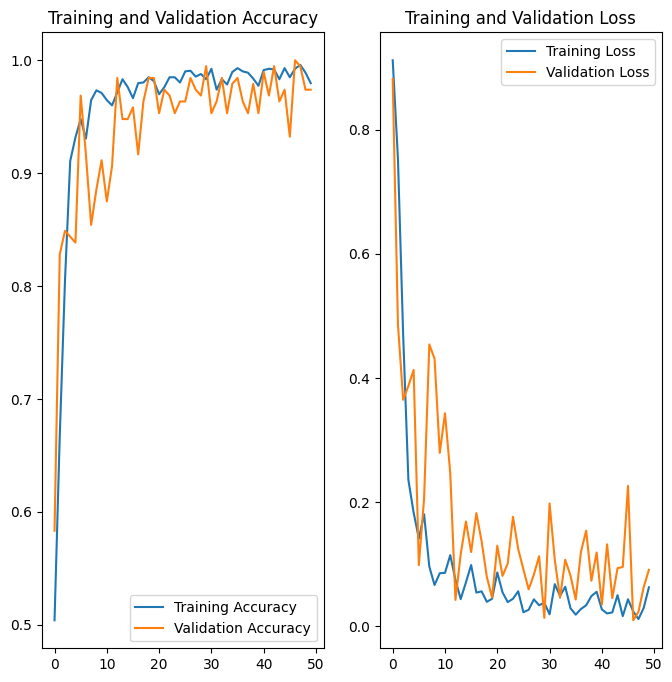

In [79]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 5s 5s/step
predicted label: Potato___Late_blight


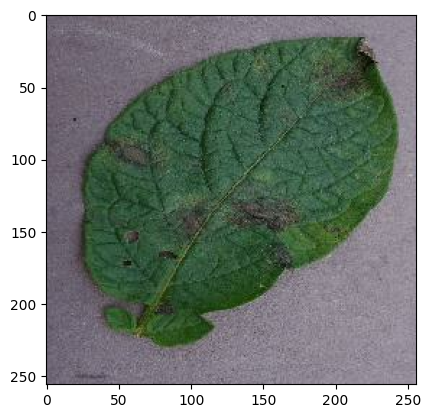

In [84]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [86]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 66ms/step


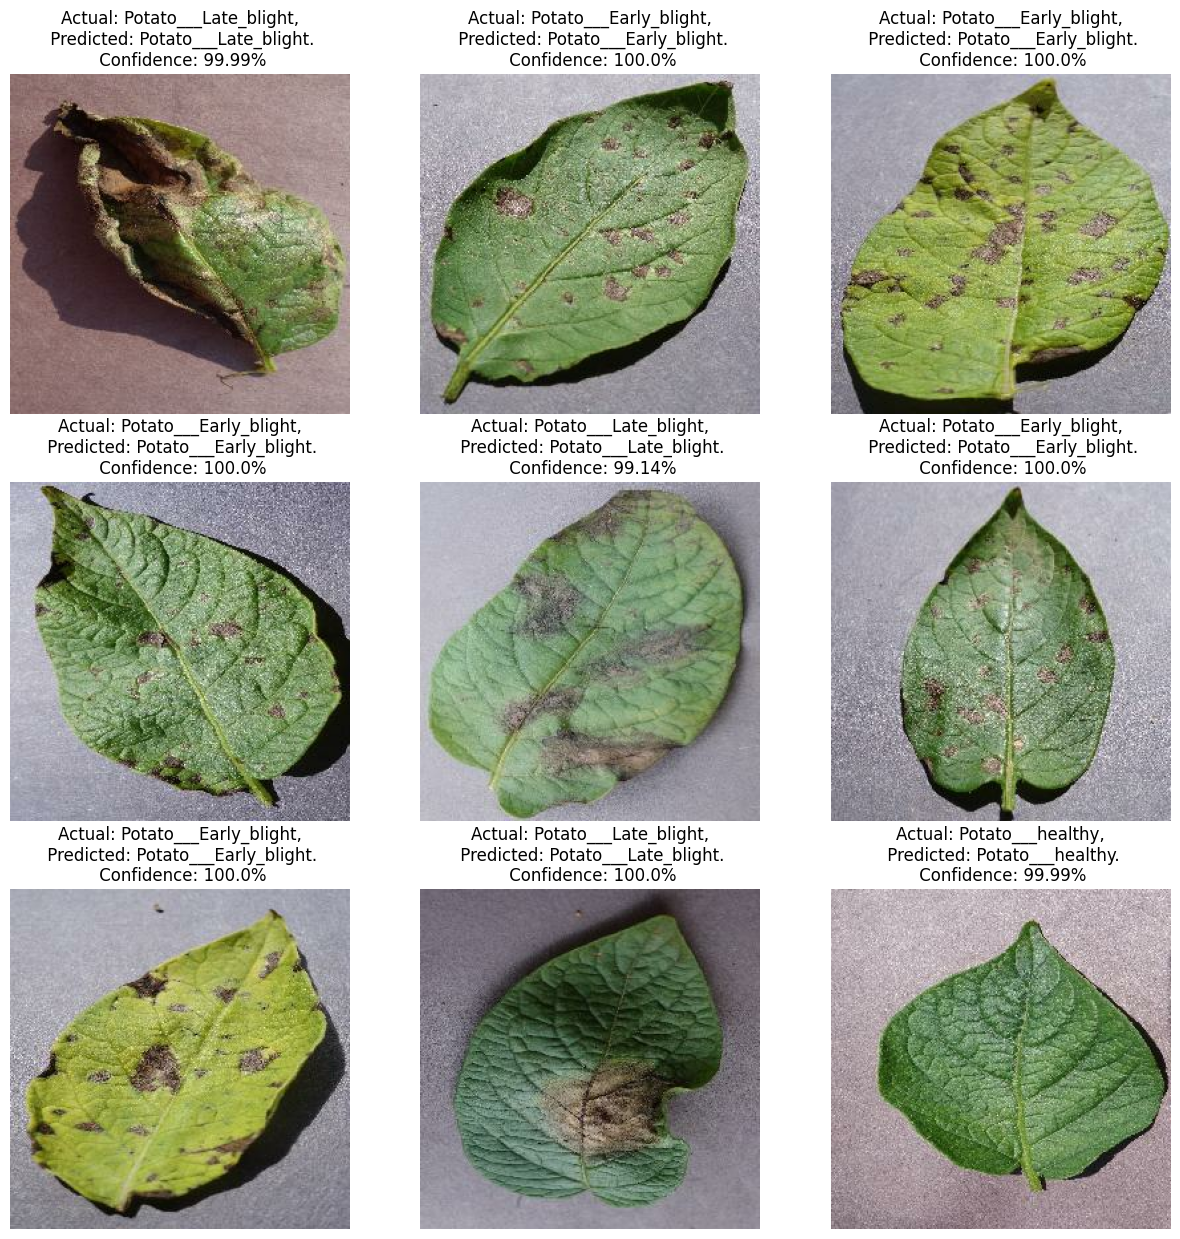

In [87]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [91]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/4\assets


INFO:tensorflow:Assets written to: ../models/4\assets
